In [4]:
import math
import numpy
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
from numba import cuda
#number of threads per block
NTHREADS = 128
%matplotlib notebook

"""
This is an object which will solve a segment of a distributed wave soln

xvals  the domain which is covered(Note: only uniform grids are allowed)
f      the function describing the initial state
g      the function describing the initial time derivative
alpha  decay parameter
c      speed of propogation c 
cfl   cfl condition
"""
class lineSegment:
    """set the state variables and step forward in time once  """
    def __init__(self , xdomain, f , g , c, cfl ):
        self.beta_  = 2
        self.xvals_ = xdomain
        self.h_    = self.xvals_[1]-self.xvals_[0]
        self.a_     = self.xvals_[0]
        self.b_     = self.xvals_[-1]
        #self.dt_    = self.h_/c*cfl
        #self.alpha_ = self.beta_/(c*self.dt_)
        self.uprev_ = []
        self.ucurr_ = []
        self.c_     = c
        self.f_     = f
        self.g_     = g
    
    def getAlphaDistance(self):
        return self.alpha_*(self.b_-self.a_)
    
    def __len__(self):
        return len(self.xvals_)
        
    """the first timestep is done with a 2nd order taylor expansion"""
    def taylorStep(self):
        #we need to set the initial state 
        for xi in self.xvals_:
            fval = self.f_(xi)
            self.uprev_.append(fval)
            #self.ucurr_.append(fval + self.dt_*g(xi))
            self.ucurr_.append(1/2*(self.f_(xi-self.c_*self.dt_)+ self.f_(xi+self.c_*self.dt_) + self.dt_*(self.g_(xi-self.c_*self.dt_)+self.g_(xi+self.c_*self.dt_))))
        #self.ucurr_[0] = (self.ucurr_[0]+self.ucurr_[-1])/2
        #self.ucurr_[-1] = self.ucurr_[0]
    
    """time steps cannot be determined until all subgrids are made"""
    def setTimestep(self , dt):
        self.dt_ = dt
        self.alpha_ = self.beta_/(self.c_*self.dt_) 
        
        self.calcUniformQuadWeights()
        self.taylorStep()
       
    """the the mesh is not adaptive, many constants are the same"""
    def calcUniformQuadWeights( self ):
            
            #assume uniform step size
            
            self.vj_    = self.alpha_*self.h_
            self.dj_    = math.exp(-self.vj_) 
            
            ratio = (1-self.dj_)/self.vj_
            eps = 1e-3
            self.Q_     = -self.dj_ + ratio

            #if things get small, this blows up 
            if self.vj_>eps:
                self.P_ = 1 - ratio
                self.R_ = 1-self.dj_-self.vj_/2*(1+self.dj_ )
            else:
                self.P_ = (self.h_/2-self.h_**2/6+self.h_**3/24-self.h_**4/120)
                self.R_ = -math.exp(-self.h_/2)*(self.h_**3/12+self.h_**5/480+self.h_**7/53760)

    """get the current value of u"""
    def getState(self):
        return self.ucurr_
    
    """
    calculate the local contribution of the solution and report the endpoints
    THIS WILL LIKELY BE THE THING TO PARALLELIZE
    """
    def calcLocalContribution( self, uvals = -1):
        if uvals == -1:
            uvals = self.ucurr_
        
        quadCoeffs = []  
        size = len(self.xvals_)    
        
        JLval = [0]
        JRval = [0]
        
        #do a finite difference stencil for the second derivative at every point
        #in our mesh. do a 4 point stencil at the ends to preserve accuracy
        for i in range(size):
            if i != 0 and i != (size-1):
                quadCoeffs.append((uvals[i-1] - 2*uvals[i] + uvals[i+1])*1/self.vj_**2 )
            elif i == 0:
                quadCoeffs.append((2*uvals[0] - 5*uvals[1] + 4*uvals[2] - uvals[3])*1/self.vj_**2 )
            else:
                quadCoeffs.append((2*uvals[-1] - 5*uvals[-2] +4*uvals[-3] - uvals[-4])*1/self.vj_**2)
            #evaluate the polynomial integral for each J between 0 and N.
        for j in range(size):

            if j != 0:
                #recursive formula to update the value of J
                JLcurr  = self.P_*uvals[j] + self.Q_*uvals[j-1] + quadCoeffs[j]*self.R_
                JLval.append( self.dj_*JLval[j-1] + JLcurr )
                
            if j != size-1:
                JRreverse = self.P_*uvals[-(j+2)]+self.Q_*uvals[ -(j+1) ] + self.R_*quadCoeffs[-(j+2)] 
                JRval.append(self.dj_*JRval[j] + JRreverse)
            
        JRval.reverse()
        
        self.w_ = [JLval[i]+JRval[i]  for i in range(size)]
        return self.reportEndPoints()
    
    """update the solution with the endpoints from it's neighbors(or boundaries)"""
    def updateSoln(self , Am ,Bm):
        size = len(self.xvals_)
        self.u_ = [0]*size
        
        for i in range(size):
            self.u_[i] = self.w_[i]+Am*math.exp(-self.alpha_ *(self.xvals_[i] -self.a_ ) ) + Bm*math.exp(-self.alpha_ *(self.b_  - self.xvals_[i]))
        
    """after ALL other calculations are done,  """
    def calcFinalSoln(self):
        size = len(self.xvals_)
        
        for i in range(size):        
            self.u_[i] = self.ucurr_[i] -.5*self.u_[i]
            self.u_[i] = 2*self.ucurr_[i] - self.uprev_[i] - self.beta_**2*self.u_[i]
        
        self.uprev_ = self.ucurr_
        self.ucurr_ = self.u_
    
    """pass the end points of the segment up to the global solver"""
    def reportEndPoints(self):
        return [self.w_[0] , self.w_[-1]]
    
    """report the solution at a given timestep"""
    def getSoln(self):
        return self.ucurr_
    
    def getDist(self):
        return self.h_
    
    """calculate JLval and JRreverse in cuda """
    def calcLocalContributionCuda( self ):
        return None

In [10]:
"""
class to solve wave equation in a distributed manner
xdomain is a list of lists that contains x vals, each sublist must be monotonicly increasing
f       is the initial position of the wave at time 0
g       is the initial velocity of the wave at time 0
T       is the end time
cfl     is a relationship between the time and spatial discretization
c       is the speed of wave propogation
bcs     is the desired boundary conditions, options are "neu", "dirch", and "period"
"""
#NOTE: may want to change xdomains to [[a1,b1],[a2,b2]...] for more convenience
class waveHandler:
    def __init__( self , xdomains, f ,g, T, cfl , c , bcs):
    
        self.beta_ = 2
        self.segments   = []
        self.end_       = T
        #use finest mesh
        self.dt_         = 5# not actual value(xdomains[0][1]-xdomains[0][0])/c*cfl
        self.leftComm_   = []
        self.rightComm_  = []
        self.Ileft_      = [0]
        self.Iright_     = [0]
        self.domainSize_ = xdomains[-1][-1]-xdomains[0][0]
        
        self.bcType_ = bcs
        
        
        #create a segment for each seperate domain
        for xdomain in xdomains:
            newSegment = lineSegment(xdomain , f , g , c, cfl )
            
            dtCandidate = newSegment.getDist()*cfl/c
            
            if self.dt_>dtCandidate:
                self.dt_ = dtCandidate
                
            self.segments.append(newSegment)
       
        self.alpha_ = self.beta_/(c*self.dt_)
        self.damping_ = math.exp(-self.alpha_*(self.domainSize_))

        for currsegment in self.segments:
            currsegment.setTimestep(self.dt_)
        
        self.segmentLen = len(self.segments)
        self.time_ = 2*self.dt_
        #need to figure out how to make time steps should it be based off of largest things?
        
    """
    propogate the solution to the specified time. Maybe have another option
    for arbitrary time stepping?
    """
    def propogate(self):
        self.calcTimeStep()
        self.meshSolns()
            
            
    """
    waveHandler should know about the BC's, segments shouldn't have any idea
    what the boundary conditions are, this will set the correct bc conditions
    """
    def applyBCs(self, leftEnds , rightEnds):
        if self.bcType_ == 'periodic':
            self.BC1_ = leftEnds/(1-self.damping_)
            self.BC2_ = rightEnds/(1-self.damping_)
    
    """do local contributions for each segment, and then calculate """
    def calcTimeStep(self):
        #need to reset the 'memory'
        self.leftComm_  = [0]*self.segmentLen
        self.rightComm_ = [0]*self.segmentLen
        
        self.A_    = [0]*self.segmentLen
        self.B_    = [0]*self.segmentLen
        #BCends = [ 0 , 0]
        
        #calculate local contributions, and report the end points
        for segmentIndex in range(self.segmentLen):
            segment   = self.segments[segmentIndex]
            
            endpoints = segment.calcLocalContribution()

            self.leftComm_[self.segmentLen-segmentIndex-1] = endpoints[0]
            self.rightComm_[segmentIndex] = endpoints[1]

        JL = self.rightComm_[0]
        JR = self.leftComm_[0]
        #print(self.rightComm_,self.leftComm_)
        
        distanceScalar = 1
        
        for segmentIndex in range(1,self.segmentLen):
            segment  = self.segments[segmentIndex]
            expAlphaDistance = math.exp(-segment.getAlphaDistance())
            
            self.A_[segmentIndex] = JL
            self.B_[self.segmentLen-segmentIndex-1]=JR
            
            distanceScalar*=expAlphaDistance
            
            JL = JL*distanceScalar + self.rightComm_[segmentIndex]
            JR = JR*distanceScalar + self.leftComm_[segmentIndex]
        self.applyBCs(JL,JR)

        distanceScalar = 1
        for segmentIndex , segment in enumerate(self.segments):
            self.A_[segmentIndex] += distanceScalar*self.BC1_
            self.B_[self.segmentLen-segmentIndex-1] += distanceScalar*self.BC2_

            expAlphaDistance = math.exp(-segment.getAlphaDistance())
            distanceScalar *=expAlphaDistance
        
        #self.B_.reverse
        #print(self.A_,self.B_)
        for segmentIndex in range(self.segmentLen):
            currSegment  = self.segments[segmentIndex]
            currSegment.updateSoln(self.A_[segmentIndex], self.B_[segmentIndex])
            currSegment.calcFinalSoln()

    def meshSolns(self):
        self.allSolns_ = []
        #to properly mesh grids together
        #if it's even, then take the left endpoint off 
        #if it's odd, then take the right endpoint off
        for segmentIndex,segment in enumerate(self.segments):
            if segmentIndex == 0:
                self.allSolns_+= list(segment.getState())
            else:
                self.allSolns_+=list(segment.getState()[1:len(segment)])
        #print(len(self.allSolns_))
        
    def getSolns(self):
        return self.allSolns_
        #segments[0].applyBCs()
        #segment[-1].applyBcs()

In [23]:

T = .5
a = -2
b = 2
N = 1696

cfl = 10
c   = 1

dt = 
f = lambda x: 0#numpy.exp(-72*((x-(a+b)/2.)/(b-a))**2.)
g = lambda x: 0#144/(b-a)**2*(x-(a+b)/2)*numpy.exp(  -72.*( (x-(a+b)/2) / (b-a) )**2)

solver =  waveHandler([x1] , f,g,T,dt,c,'periodic')
uSoln = []
for i in range(1000):
    solver.propogate()
    uSoln.append(solver.getSolns())
    #x = list(x1[0::])+list(x2[1::])+list(x3[1::])+list(x4[1::])
#print(len(x),len(uSoln[0]))
#print(x)
#x  = list(x1[0::])+list(x2[1::])

In [24]:
%time main()

Wall time: 13.3 s


In [20]:
def animate(i):
    line.set_data(x,uSoln[i])
    return line,
def init():
    line.set_data([], [])
    return line,

<IPython.core.display.Javascript object>


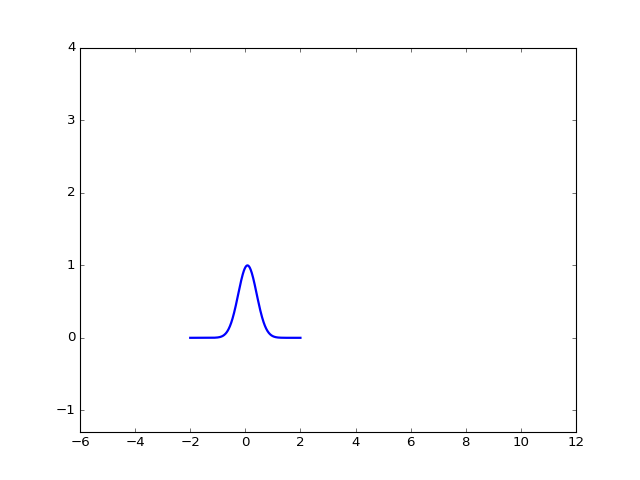

In [40]:
fig   = plt.figure()
ax    = plt.axes(xlim=(-6,12),ylim = (-1.3,4))
line, = ax.plot([],[] , lw=2)
anim = animation.FuncAnimation(fig,animate, frames = len(uSoln),interval=50,blit=True)